# $\Lambda_B$ Decay Mode
In this notebook we aim to use the analysis techniques we have made and tuned in a complete fashion. In this way we can estimate our sensitibity in the rare mode. We hope this value is similar to that which could actually be achieved but this is not known since we do not have an unblinded rare mode.

However, we will do a similar test in the normalisation mode. If that works well we can reasonably conclude that our system of analyses works well.

In [1]:
# Set enviornment variables
import os
os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
# Suppress some warnings from TensorFlow related to zfit

In [2]:
import tensorflow as tf
import zfit
from zfit import z
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

2022-03-30 15:03:17.417621: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-30 15:03:17.417725: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Data
Ordinarily we would use the standard create_data framework to generate our data for us. In this rare mode case it has already been done for us, yay!

In [30]:
test = pd.read_csv('../../../mnt/d/University/Y4/Project/localproject/9.0.4/test.csv', index_col=[0])
test.head()

X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test[['category', 'Lb_M', 'IsSimulated']]

# Inspect Data
To gauge how good our techniques are it is first good to know how many signal and how many background events there are in these data.

In [31]:
print(f"There are {test.category.value_counts()[0]} background events")
print(f"There are {test.category.value_counts()[1]} signal events")

There are 3731 background events
There are 3665 signal events


Not many events but we have to recognise that we have applied quite an aggressive preselection as well as a mass region restriction further to that our test sample is only a 20% fraction of these data that we have never before seen.

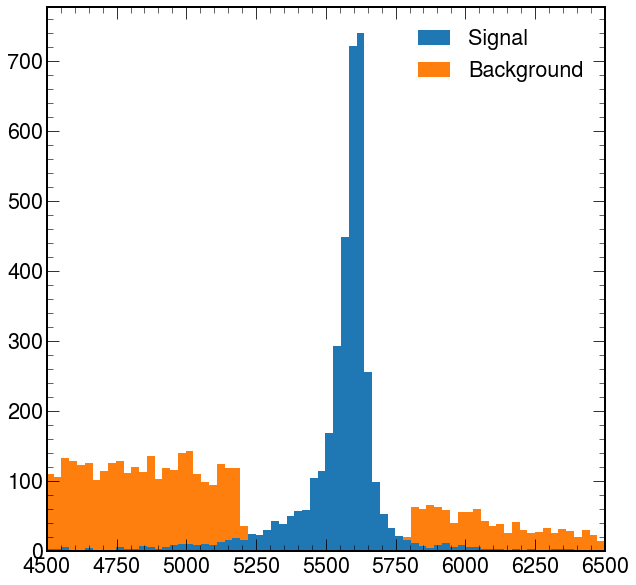

In [39]:
fig, ax = plt.subplots(1, 1)
h, bins = np.histogram(test['Lb_M'][test['category']==1], bins=100)
h1, _ = np.histogram(test['Lb_M'][test['category']==0], bins=bins)
hep.histplot([h, h1], bins=bins, yerr=[np.sqrt(h), np.sqrt(h1)], ax=ax, label=['Signal', 'Background'], histtype='fill', stack=True)
ax.set_xlim(4500, 6500)
#hep.lhcb.label(loc=0)
plt.legend()
plt.show()

# Load Model
Now we choose to load our best performing model, the neural network.

In [28]:
model = tf.keras.models.load_model('../neural_network/models/v9.0.5')

2022-03-30 16:15:16.775373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-30 16:15:16.779667: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-30 16:15:16.781851: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-0L9OF1GC): /proc/driver/nvidia/version does not exist
2022-03-30 16:15:16.798741: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
# Make predictions with our model
predictions = model.predict(X_test).flatten()
print(predictions[0:10])

[1.6713518e-01 9.9114811e-01 4.8980117e-04 9.7456038e-01 3.4451932e-02
 2.3385882e-04 4.8476458e-04 5.2800775e-04 5.9075499e-01 9.4914752e-01]


In [35]:
# Make these predictions into classes following our Punzi FOM analysis
predicted_classes = np.where(predictions > 0.8, 1, 0)
print(predicted_classes[0:10])

[0 1 0 1 0 0 0 0 0 1]


In [36]:
# Append these predictions to the origina dataframe
test['predicted_class'] = predicted_classes

# Evaluate Cut
Now we have made the cut we need to actually evaluate it

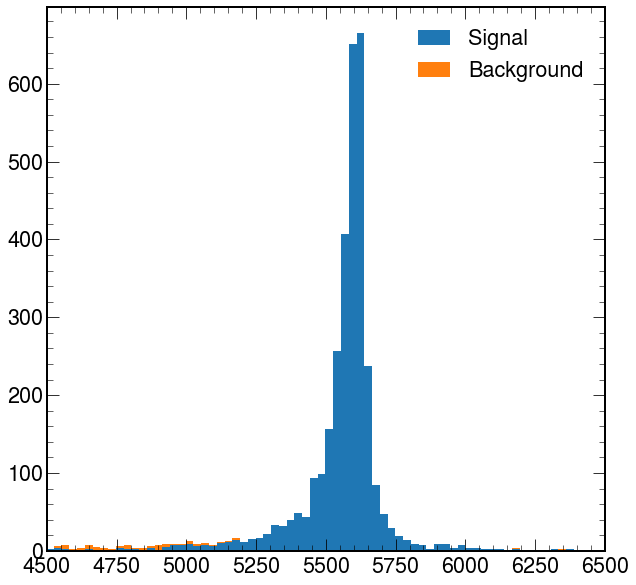

In [40]:
fig, ax = plt.subplots(1, 1)
h, _ = np.histogram(test['Lb_M'][np.logical_and(test['category']==1,test['predicted_class']==1)], bins=bins)
h1, _ = np.histogram(test['Lb_M'][np.logical_and(test['category']==0,test['predicted_class']==1)], bins=bins)
hep.histplot([h, h1], bins=bins, yerr=[np.sqrt(h), np.sqrt(h1)], ax=ax, label=['Signal', 'Background'], histtype='fill', stack=True)
ax.set_xlim(4500, 6500)
#hep.lhcb.label(loc=0)
plt.legend()
plt.show()

In [44]:
# What was the signal purity, i.e. of all that you selected how much was signal?
purity = np.count_nonzero(np.logical_and(test['predicted_class']==1,test['category']==1))/np.count_nonzero(test['predicted_class'])
print(f"Cut Purity: {(purity*100):.3f}%")

# What was the rate of signal selection i.e. of all the signal in the sample how much did we get?
selection_rate = np.count_nonzero(np.logical_and(test['predicted_class']==1,test['category']==1))/np.count_nonzero(test['category'])
print(f"Signal Selection Rate: {(selection_rate*100):.3f}%")

Cut Purity: 97.720%
Signal Selection Rate: 87.694%


# Refit DCB Using Residual Mass Distribution
We do this as this is what we would actually do if we could not just look at the real event type. We can then integrate this function between our signal region (blinded) and use this to estimate our number of signal events. We can then compare that with uncertanties to the actual value of signal events in our sample.

In [45]:
masses = test['Lb_M'][test['predicted_class']==1].to_numpy()
obs = zfit.Space('x', limits=(np.min(masses), np.max(masses)))

mu = zfit.Parameter("mu", 5611.0, 5580.0, 5680.0)
sigma = zfit.Parameter("sigma", 21.79, 15, 35)
alphal = zfit.Parameter("alphal", 0.4458, -1, 1)
nl = zfit.Parameter("nl", 2.637, -3, 3)
alphar = zfit.Parameter("alphar", 1.1333, -2, 2)
nr = zfit.Parameter("nr", 2.057, -3, 3)

In [46]:
dcb = zfit.pdf.DoubleCB(obs=obs, mu=mu, sigma=sigma, alphal=alphal, nl=nl,
alphar=alphar, nr=nr)
data = zfit.Data.from_numpy(obs=obs, array=masses)

In [ ]:
nll = zfit.loss.UnbinnedNLL(model=dcb, data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
# Only allow some parameters to float e.g. an amplitude